# Titanic Dataset - a Machine Learning project by Abhinandan Padhi
## Includes Exploratory Data Analysis, Feature Engineering, and Various ML Techniques



## Exploratory Data Analysis (EDA)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
count, num_features = train.shape
print("Number of training examples (count) = {}, Number of features = {}".format(count, num_features))

Number of training examples (count) = 891, Number of features = 12


In [5]:
# Check for missing data (NaN values) in the training set:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

There are null values for the Age, Cabin, and Embarked columns. Age and Embarked columns might be useful to predict survival rate, and so, these missing values will be addressed by data imputation later on in this notebook.

Overall survival rate: 38.4%


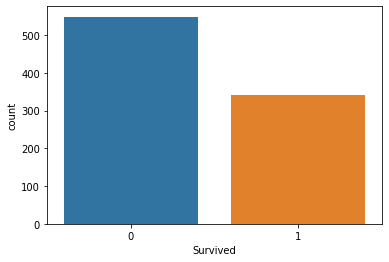

In [6]:
sb.countplot(x='Survived', data=train)
print("Overall survival rate: {:.1f}%".format(100*train['Survived'].sum()/count))

## Survival Analysis for each Feature (Column)

Male:Female ratio = 65:35
Male Survival Rate = 18.9%
Female Survival Rate = 74.2%


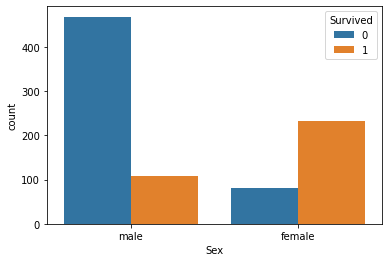

In [7]:
# Sex (Gender)
sb.countplot(x='Sex', hue='Survived', data=train)
print("Male:Female ratio = {:.0f}:{:.0f}".format(100*(train['Sex'] == 'male').sum()/count, 100*(train['Sex'] == 'female').sum()/count))
print("Male Survival Rate = {:.1f}%\nFemale Survival Rate = {:.1f}%".format(100*((train['Sex'] == 'male') & (train['Survived'] == 1)).sum()/(train['Sex'] == 'male').sum(),
                                                               100*((train['Sex'] == 'female') & (train['Survived'] == 1)).sum()/(train['Sex'] == 'female').sum()))

Females clearly have a very high survival rate - this will be important for the ML models later on.

Number of people in Class 1 = 216
Survival Rate for class 1 = 63.0%
Number of people in Class 2 = 184
Survival Rate for class 2 = 47.3%
Number of people in Class 3 = 491
Survival Rate for class 3 = 24.2%


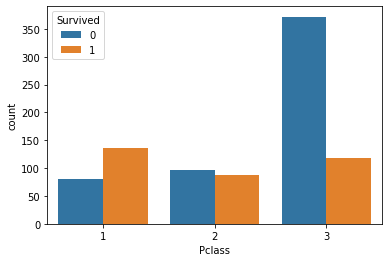

In [8]:
# Pclass (Ticket Class)
sb.countplot(x='Pclass', hue='Survived', data=train)

for val in np.sort(train['Pclass'].unique()):
  print("Number of people in Class {} = {}".format(val, (train['Pclass'] == val).sum()))
  print("Survival Rate for class {} = {:.1f}%".format(val, 100*((train['Pclass'] == val) & (train['Survived'] == 1)).sum()/(train['Pclass'] == val).sum()))

It appears that people in class 1 (first class?) had the highest survival rate of all classes.

In [9]:
# Defined a function to analyse the data for a single specified feature (w.r.t. another feature)
def feature_analysis(feature, feature_2='Survived', csv_filename='train.csv'):
  data = pd.read_csv(csv_filename)
  sb.countplot(x=feature, hue=feature_2, data=data)

  for val in np.sort(data[feature].dropna().unique()):
    print("Count for {} - {} = {}".format(feature, val, (data[feature] == val).sum()))
    print("Survival Rate for {} - {} = {:.1f}%".format(feature, val, 100*((data[feature] == val) & (data[feature_2] == 1)).sum()/(data[feature] == val).sum()))

Count for Sex - female = 314
Survival Rate for Sex - female = 74.2%
Count for Sex - male = 577
Survival Rate for Sex - male = 18.9%


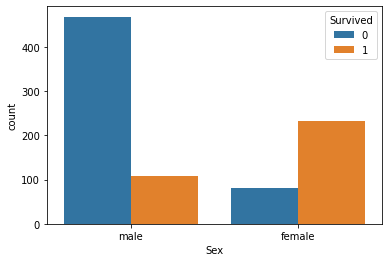

In [10]:
feature_analysis('Sex') # Used my custom function here. Identical to results from before.

Count for Pclass - 1 = 216
Survival Rate for Pclass - 1 = 63.0%
Count for Pclass - 2 = 184
Survival Rate for Pclass - 2 = 47.3%
Count for Pclass - 3 = 491
Survival Rate for Pclass - 3 = 24.2%


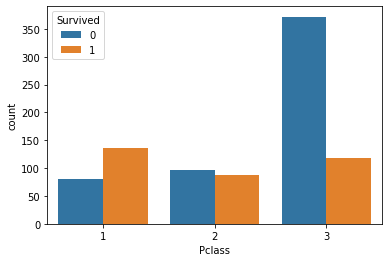

In [11]:
feature_analysis('Pclass')

Count for Embarked - C = 168
Survival Rate for Embarked - C = 55.4%
Count for Embarked - Q = 77
Survival Rate for Embarked - Q = 39.0%
Count for Embarked - S = 644
Survival Rate for Embarked - S = 33.7%


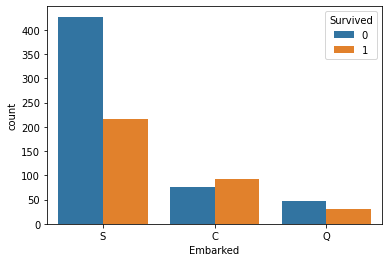

In [12]:
feature_analysis('Embarked')

We can infer that:

1) Most people on the Titanic had embarked value of 'S'.

2) People whose embarked column had value 'C' had high survival rate.

In [13]:
# Age
train['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

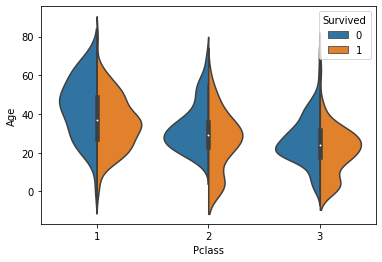

In [14]:
# Violin plot
sb.violinplot('Pclass', 'Age', hue='Survived', data=train, split=True)

From classes 2 and 3, it seems that children were given higher priorities due to small peaks below age 20. Also, younger people generally have a higher survival rate.

Considering that children and women had relatively higher survival rates, we can assume that women and children were given higher priorities for the limited life boats on the Titanic. 

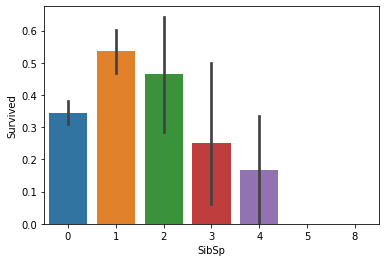

In [15]:
# SibSp (Siblings and Spouses)
sb.barplot(x='SibSp', y='Survived', data=train)

It appears that people with 1 or 2 siblings/spouses have relatively higher survival rate.

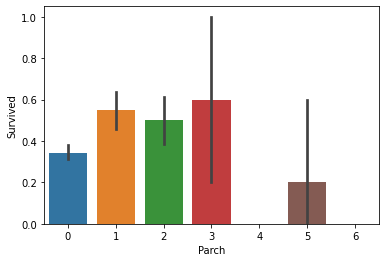

In [16]:
# Parch (Parents and Children)
sb.barplot(x='Parch', y='Survived', data=train)

It appears that people with 1 to 3 parents/children have relatively higher survival rate.

From the plots for both SibSp and Parch, it seems that a person with a small family has higher chance of survival. Conversely, people who are alone or have large families have lower chance of survival.

## Encoding Categorical Data, Feature Engineering and Data Imputation

In [17]:
X_train = train.drop(['PassengerId', 'Cabin', 'Ticket', 'Fare'], axis=1)
y_train = train.Survived
X_train = X_train.drop(['Survived'], axis=1)
X_train.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,S


In [18]:
X_test = test.drop(['PassengerId', 'Cabin', 'Ticket', 'Fare'], axis=1)
X_test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Embarked
0,3,"Kelly, Mr. James",male,34.5,0,0,Q
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,S
2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,Q
3,3,"Wirz, Mr. Albert",male,27.0,0,0,S
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,S


In [19]:
# Encoding Sex
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X_train['Sex'] = le.fit_transform(X_train['Sex'])

In [20]:
# Encoding Sex (test set)
X_test['Sex'] = le.transform(X_test['Sex'])

In [21]:
# One-Hot Encoding Pclass
Pclass_train = pd.get_dummies(X_train.Pclass, prefix='Pclass')
Pclass_test = pd.get_dummies(X_test.Pclass, prefix='Pclass')
X_train = X_train.drop(['Pclass'], axis=1)
X_test = X_test.drop(['Pclass'], axis=1)
X_train = pd.concat([X_train, Pclass_train], axis=1)
X_test = pd.concat([X_test, Pclass_test], axis=1)

In [22]:
# Take care of missing values for Embarked column
null_indices = X_train['Embarked'].isnull()
X_train.loc[null_indices, 'Embarked'] = 'S'

# One-Hot Encoding Embarked
Embarked_train = pd.get_dummies(X_train.Embarked, prefix='Embarked')
Embarked_test = pd.get_dummies(X_test.Embarked, prefix='Embarked')
X_train = X_train.drop(['Embarked'], axis=1)
X_test = X_test.drop(['Embarked'], axis=1)
X_train = pd.concat([X_train, Embarked_train], axis=1)
X_test = pd.concat([X_test, Embarked_test], axis=1)

In [23]:
X_train.head()

,Name,Sex,Age,SibSp,Parch,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,"Braund, Mr. Owen Harris",1,22.0,1,0,0,0,1,0,0,1
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,1,0,0,1,0,0
2,"Heikkinen, Miss. Laina",0,26.0,0,0,0,0,1,0,0,1
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,1,0,0,0,0,1
4,"Allen, Mr. William Henry",1,35.0,0,0,0,0,1,0,0,1


In [24]:
X_test.head()

,Name,Sex,Age,SibSp,Parch,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,"Kelly, Mr. James",1,34.5,0,0,0,0,1,0,1,0
1,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,0,0,1,0,0,1
2,"Myles, Mr. Thomas Francis",1,62.0,0,0,0,1,0,0,1,0
3,"Wirz, Mr. Albert",1,27.0,0,0,0,0,1,0,0,1
4,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,0,0,1,0,0,1


In [25]:
# Imputing Missing Values of Age - by engineering a new feature called "Title" 
# Title examples - 'Mr.', 'Miss.', etc.
# Train set

temp = X_train.Name.str.split(',').str[1]
X_train.iloc[:, 0] = pd.DataFrame(temp).Name.str.split('\s+').str[1]
X_train.head()

,Name,Sex,Age,SibSp,Parch,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,Mr.,1,22.0,1,0,0,0,1,0,0,1
1,Mrs.,0,38.0,1,0,1,0,0,1,0,0
2,Miss.,0,26.0,0,0,0,0,1,0,0,1
3,Mrs.,0,35.0,1,0,1,0,0,0,0,1
4,Mr.,1,35.0,0,0,0,0,1,0,0,1


In [26]:
# Imputing Missing Values of Age - by engineering a new feature called "Title" 
# Title examples - 'Mr.', 'Miss.', etc.
# Test set

temp = X_test.Name.str.split(',').str[1]
X_test.iloc[:, 0] = pd.DataFrame(temp).Name.str.split('\s+').str[1]
X_test.head()

,Name,Sex,Age,SibSp,Parch,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,Mr.,1,34.5,0,0,0,0,1,0,1,0
1,Mrs.,0,47.0,1,0,0,0,1,0,0,1
2,Mr.,1,62.0,0,0,0,1,0,0,1,0
3,Mr.,1,27.0,0,0,0,0,1,0,0,1
4,Mrs.,0,22.0,1,1,0,0,1,0,0,1


In [27]:
X_train = X_train.rename(columns={'Name': 'Title'})
X_test = X_test.rename(columns={'Name': 'Title'})

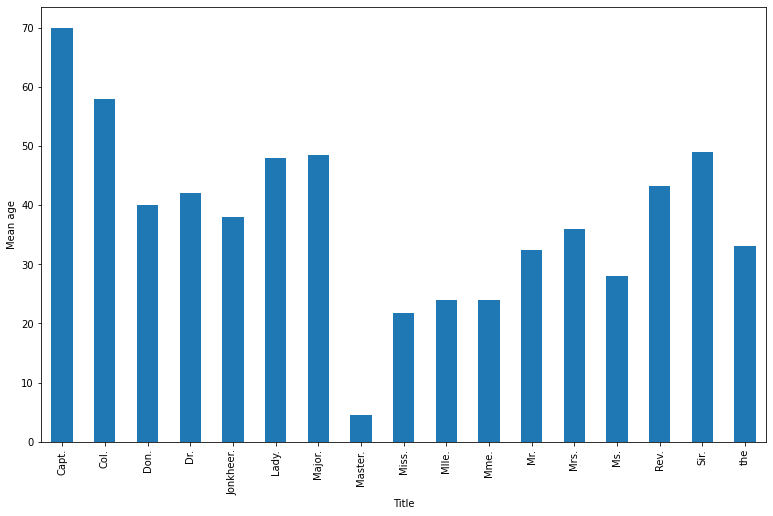

In [28]:
#List of different titles
ax = plt.subplot()
ax.set_ylabel('Mean age')
X_train.groupby('Title').mean()['Age'].plot(kind='bar',figsize=(13,8), ax = ax)

In [29]:
X_train.Title.unique()

array(['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Don.', 'Rev.', 'Dr.', 'Mme.',
       'Ms.', 'Major.', 'Lady.', 'Sir.', 'Mlle.', 'Col.', 'Capt.', 'the',
       'Jonkheer.'], dtype=object)

In [30]:
title_age_dict = X_train.groupby('Title')['Age'].mean().to_dict()
title_age_dict

{'Capt.': 70.0,
 'Col.': 58.0,
 'Don.': 40.0,
 'Dr.': 42.0,
 'Jonkheer.': 38.0,
 'Lady.': 48.0,
 'Major.': 48.5,
 'Master.': 4.574166666666667,
 'Miss.': 21.773972602739725,
 'Mlle.': 24.0,
 'Mme.': 24.0,
 'Mr.': 32.368090452261306,
 'Mrs.': 35.898148148148145,
 'Ms.': 28.0,
 'Rev.': 43.166666666666664,
 'Sir.': 49.0,
 'the': 33.0}

In [31]:
for title, age in title_age_dict.items():
  X_train.loc[(X_train.Age.isnull()) & (X_train['Title'] == title), 'Age'] = age
  X_test.loc[(X_test.Age.isnull()) & (X_test['Title'] == title), 'Age'] = age

In [32]:
X_train.head()

,Title,Sex,Age,SibSp,Parch,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,Mr.,1,22.0,1,0,0,0,1,0,0,1
1,Mrs.,0,38.0,1,0,1,0,0,1,0,0
2,Miss.,0,26.0,0,0,0,0,1,0,0,1
3,Mrs.,0,35.0,1,0,1,0,0,0,0,1
4,Mr.,1,35.0,0,0,0,0,1,0,0,1


In [33]:
X_train = X_train.drop(['Title'], axis=1)
X_test = X_test.drop(['Title'], axis=1)

In [63]:
X_train.head()

,Sex,Age,SibSp,Parch,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,22.0,1,0,0,0,1,0,0,1
1,0,38.0,1,0,1,0,0,1,0,0
2,0,26.0,0,0,0,0,1,0,0,1
3,0,35.0,1,0,1,0,0,0,0,1
4,1,35.0,0,0,0,0,1,0,0,1


### Machine Learning! Testing various Classification techniques/models

In [47]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
classifierLR = LogisticRegression(random_state = 0, max_iter=200)

# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifierLR, X=X_train , y=y_train , cv = 10)
print("Logistic Regression:\nAccuracy:", accuracies.mean(), "+/-", accuracies.std(),"\n")

Logistic Regression:
Accuracy: 0.8024843945068664 +/- 0.01875058388183171 



In [48]:
# Support Vector Machine (SVM) with RBF kernel
from sklearn.svm import SVC
classifierSVM = SVC(kernel = 'rbf', random_state = 0, C=10)

# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifierSVM, X=X_train , y=y_train , cv = 10)
print("SVM:\nAccuracy:", accuracies.mean(), "+/-", accuracies.std(),"\n")

SVM:
Accuracy: 0.8170162297128589 +/- 0.037107940613126104 



In [49]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB
classifierNB = GaussianNB()

# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifierNB, X=X_train , y=y_train , cv = 10)
print("Naive Bayes:\nAccuracy:", accuracies.mean(), "+/-", accuracies.std(),"\n")

Naive Bayes:
Accuracy: 0.76541822721598 +/- 0.03505625980335946 



In [50]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
classifierRF = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)

# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifierRF, X=X_train , y=y_train , cv = 10)
print("Random Forest:\n Accuracy:", accuracies.mean(), "+/-", accuracies.std())

Random Forest:
 Accuracy: 0.7992384519350811 +/- 0.0504793473953388


In [51]:
# K-Nearest Neighbours (KNN)
from sklearn.neighbors import KNeighborsClassifier
classifierKNN = KNeighborsClassifier(n_neighbors = 9, metric = 'minkowski', p = 2)


# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifierKNN, X=X_train , y=y_train , cv = 10)
print("K-NN:\n Accuracy:", accuracies.mean(), "+/-", accuracies.std(),"\n")

K-NN:
 Accuracy: 0.7677028714107366 +/- 0.028642479733341282 



In [52]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
classifierDT = DecisionTreeClassifier(random_state = 0, criterion='entropy')

# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifierDT, X=X_train , y=y_train , cv = 10)
print("Decision Tree:\n Accuracy:", accuracies.mean(), "+/-", accuracies.std(),"\n")

Decision Tree:
 Accuracy: 0.7846192259675405 +/- 0.04716579791343462 



In [64]:
classifierRF.fit(X_train, y_train)
y_pred = classifierRF.predict(X_test)
y_pred

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,

In [65]:
output = pd.DataFrame({'PassengerID' : test.PassengerId, 'Survived' : y_pred})
output.to_csv('submission_RF.csv', index = False)

I tried predicting the survived values for the test set using all the classifiers above (LR, SVM, NB, RF, KNN, DT), and saved the predicted values (y_pred values) to a csv as required for the submission and submitted each of the csv files. 


Random Forest had the best test set accuracy at around 77% even though Logistic Regression had the best K-fold cross validation accuracy.

## Improving the score by using Stacking with Out Of Fold (OOF) Prediction

I will be using the Random Forest and SVM classifiers from above and combine with three other classification models - AdaBoost, Gradient Boosting, and Extra Trees.

Meaning of Stacking - The 5 (base) models will be used to produce a first layer of predictions, and then, the famous XGBoost model will be used to produce a second layer prediction.

In [67]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

In [91]:
# Some constants first
seed = 0 
nfolds = 5 # set folds for out-of-fold prediction

num_train = train.shape[0]
num_test = test.shape[0]

kf = KFold(n_splits=nfolds, random_state=seed)

# Helper Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)

### First Level OOF predictions for Stacking

In [89]:
def out_of_fold_predictor(clf, x_train, y_train, x_test):
    oof_train = np.zeros((num_train,))
    oof_test = np.zeros((num_test,))
    oof_test_skf = np.empty((nfolds, num_test))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [73]:
# Parameters for base classifiers

# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

In [75]:
# Create 5 objects (instances of SkleanHelper class) that represent the 5 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=seed, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=seed, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=seed, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=seed, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=seed, params=svc_params)

In [76]:
# Create Numpy arrays for X_train, X_test and y_train from their dataframes to feed into our models
y_train = y_train.ravel()
X_train = X_train.values # Creates an array of the train data
X_test = X_test.values # Creats an array of the test data

In [82]:
print("X_train shape:", X_train.shape)
X_train

X_train shape: (891, 10)


array([[ 1.       , 22.       ,  1.       , ...,  0.       ,  0.       ,
         1.       ],
       [ 0.       , 38.       ,  1.       , ...,  1.       ,  0.       ,
         0.       ],
       [ 0.       , 26.       ,  0.       , ...,  0.       ,  0.       ,
         1.       ],
       ...,
       [ 0.       , 21.7739726,  1.       , ...,  0.       ,  0.       ,
         1.       ],
       [ 1.       , 26.       ,  0.       , ...,  1.       ,  0.       ,
         0.       ],
       [ 1.       , 32.       ,  0.       , ...,  0.       ,  1.       ,
         0.       ]])

In [90]:
# Now I will feed the training and test data into the 5 base classifiers
# and use the Out-of-Fold prediction function defined earlier to generate the first level predictions.

# Create our OOF train and test predictions. These base results will be used as new features for second level (XGBoost)
et_oof_train, et_oof_test   = out_of_fold_predictor(et, X_train, y_train, X_test)  # Extra Trees
rf_oof_train, rf_oof_test   = out_of_fold_predictor(rf, X_train, y_train, X_test)  # Random Forest
ada_oof_train, ada_oof_test = out_of_fold_predictor(ada, X_train, y_train, X_test) # AdaBoost 
gb_oof_train, gb_oof_test   = out_of_fold_predictor(gb, X_train, y_train, X_test)  # Gradient Boost
svc_oof_train, svc_oof_test = out_of_fold_predictor(svc, X_train, y_train, X_test) # Support Vector Classifier

### Second level predictions from the first level's output



### First level outputs are now the new features

Having obtained the first level predictions, one can think of it as essentially building a new set of features to be used as the columns in the training data for the next level's classifier (XGBoost).

In [93]:
base_predictions_train = pd.DataFrame( 
    {'RandomForest' : rf_oof_train.ravel(),
     'ExtraTrees'   : et_oof_train.ravel(),
     'AdaBoost'     : ada_oof_train.ravel(),
     'GradientBoost': gb_oof_train.ravel(),
     'SVM'          : svc_oof_train.ravel()
    })

base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost,SVM
0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0
2,0.0,0.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0


In [94]:
X_train2 = np.concatenate((et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
X_test2 = np.concatenate((et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

In [95]:
X_train2

array([[0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       ...,
       [0., 0., 1., 0., 1.],
       [0., 1., 1., 1., 0.],
       [0., 0., 0., 0., 0.]])

XGBoost is a very famous ML library for its boosted tree learning model. XGBoost was built to optimize large-scale boosted tree algorithms.

I will now call the XGBClassifier and fit it to the first level predictions, which is now the new X_train2 data as well as the y_train data, and use the learned model to predict the Survived values for the test data X_test2.

In [96]:
gbm = xgb.XGBClassifier(
    n_estimators = 2000,
    max_depth = 4,
    min_child_weight = 2,
    gamma = 0.9,                        
    subsample = 0.8,
    colsample_bytree = 0.8,
    objective = 'binary:logistic',
    nthread = -1,
    scale_pos_weight = 1).fit(X_train2, y_train)

predictions = gbm.predict(X_test2)

In [98]:
print("Shape of predictions array:", predictions.shape)
predictions

Shape of predictions array: (418,)


array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

### Finally, I can now generate the Stacked models submission csv file!

In [99]:
StackedModelsSubmission = pd.DataFrame({'PassengerId': test.PassengerId,
                                        'Survived'   : predictions})
StackedModelsSubmission.to_csv("submission_StackedModels.csv", index=False)

### Model accuracy increased slightly from 77% to around 80%, though more importantly, I explored Stacking and Out Of Fold (OOF) predictions, which will likely be useful for future Kaggle / Data Science competitions!

Goals for next run through this dataset:

1) Experiment further with hyperparameter tuning and regularization.

2) Conduct more extensive Exploratory Data Analysis (EDA), and use more varied plots and visualization tools.

3) Improve feature selection and engineer better features.